In [1]:
%load_ext autoreload
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter

from matplotlib import rcParams
rcParams['figure.figsize'] = 16, 12
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']

In [2]:
# Custom Code Import
%autoreload 2
from fooof.fooof import *

### Functions in dev / New funcs

In [3]:
def group_three(vec):
    """Takes array of inputs, groups by three."""
    
    return [list(vec[i:i+3]) for i in range(0, len(vec), 3)]

In [4]:
def rmse(preds, target):
    """Calculate root mean squared error."""
    
    return np.sqrt(((preds - target) ** 2).mean())

In [5]:
def abs_err_freq(preds, target):
    """Calculate the absolute error across frequencies."""
    
    return np.abs(preds - target)

## MEG Data

In [6]:
from om.core.db import OMDB
from om.core.io import load_meg_psds

In [7]:
# Get database and path details from OMDB class
db = OMDB()
# Check available subject numbers for PSD files
sub_nums = db.check_dat_files('PSD')


Number of Subjects available: 103

Subject numbers with FOOF data available: 
[111802, 124340, 195121, 215187, 218131, 220216, 245518, 265922, 320548, 339964, 369737, 386068, 390845, 403435, 405716, 431088, 504997, 548027, 559176, 604600, 704718, 704814, 719634, 756575, 978341, 100307, 102816, 105923, 106521, 109123, 111514, 112920, 113922, 116524, 116726, 140117, 146129, 153732, 154532, 156334, 158136, 162026, 162935, 164636, 166438, 172029, 174841, 175237, 175540, 181232, 185442, 187547, 189349, 191033, 191437, 191841, 192641, 195041, 198653, 204521, 205119, 212318, 212823, 214524, 221319, 223929, 233326, 248339, 250427, 255639, 257845, 283543, 293748, 352132, 352738, 353740, 358144, 406836, 433839, 512835, 555348, 559053, 568963, 581450, 599671, 601127, 660951, 662551, 665254, 667056, 706040, 707749, 715950, 725751, 735148, 783462, 814649, 877168, 891667, 898176, 912447, 917255, 990366]



In [8]:
# Get PSD files
psd_files, _ = db.check_dat_files('PSD', verbose=False)

In [9]:
# Load MEG Data
subj = 352132
psd, freqs = load_meg_psds('HCP', db.psd_path, subj)

In [10]:
# OR: load MEG data from npy file

#dat = np.load('meg_dat.npy')
#freqs = dat[0]
#psd = dat[1]

In [11]:
# Set which PSD to run
cur_psd = psd[4799, :]

In [12]:
# Fix up PSD
psd_array = np.log10(cur_psd)
psd_array = np.vstack((psd_array, psd_array))
psd_array = psd_array.T

In [13]:
# FOOOF SETTINGS
window_around_max = 3
number_of_gaussians = 6
cut_freqs = [3, 40]

In [14]:
# Run FOOOF
p_flat_real, frequency_vector, trimmed_psd, psd_fit, background_fit, gaussian_fit, background_params, oscillation_params = \
    fooof(freqs, psd_array, cut_freqs, number_of_gaussians, window_around_max)

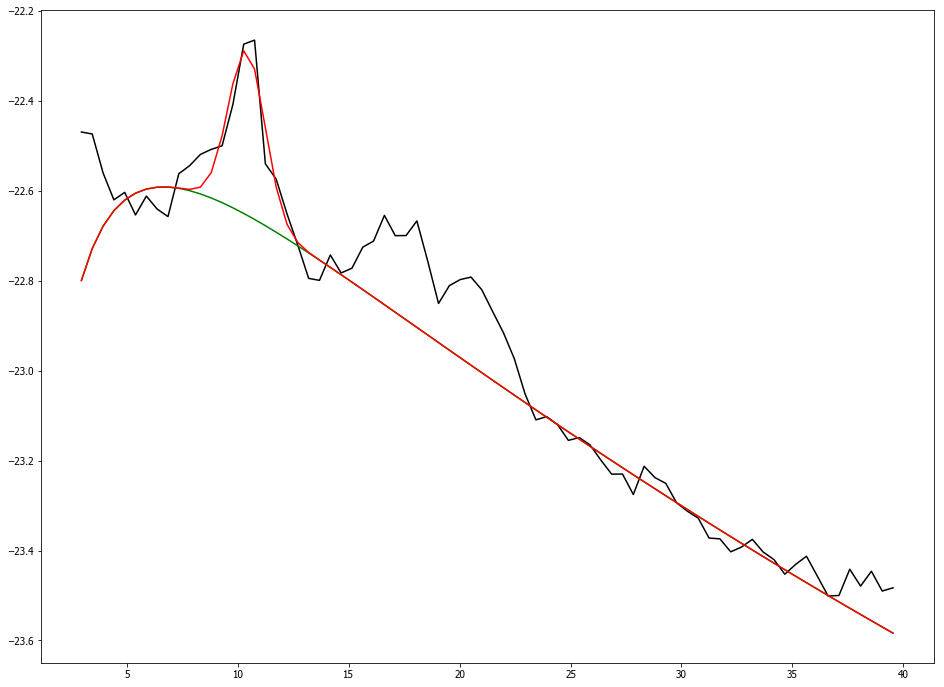

In [15]:
# Plot initial fit
plt.plot(frequency_vector, trimmed_psd, 'k')
plt.plot(frequency_vector, background_fit, 'g')
plt.plot(frequency_vector, psd_fit, 'r')

In [16]:
# Check if max error (per freq) is at f_low. If so, assume low freq is messing up fit, and update it. 
# Note: this check can/should be built into checking after background fit
#  I think it should perform the similar here, for testing purposes.
#    When background fit fails, it tends not to fit oscs anyway, so in most cases this external check reduces to be the same
#    However, if oscillations are found in first pass, doing check here, does update in a way it wouldn't otherwise (with background check)
#      ^ToDo: figure out when to do the check. 
#
# Note: eyeballing it, overall error decreases doing this. 
#  Based on examples, it is a trend that increasing f_low helps - but not a rule: there are exceptions. 
#    It's unclear if we should explore moving f_low down.

# Rather than choose a magnitude cut-off, this procedure moves f_low if the greatest error is at f_low. 
#  This check could be over-zealous - we might want to add check whether the f_low error is also an outlier
#    As in, is the error at f_low 'significantly' different than error at any other frequency.

# I'm slightly worried about jittering f_low around, in case of slight oddities comparing PSDs examined in different ranges
#  Basically, is theta interpretable / comparable across PSDs in these cases?
#  But: pragmatically - it's perhaps this, or everything is much worse overall. 
#  Anecdotally - when f_low is weird, and fit fails, there doesn't look to be theta bumps - so maybe this isn't systematically missing theta?
while np.argmax(abs_err_freq(psd_fit, trimmed_psd)) == 0:
    
    # Update cut_freqs
    cut_freqs[0] += 0.5
    
    # Re-run FOOOF
    p_flat_real, frequency_vector, trimmed_psd, psd_fit, background_fit, gaussian_fit, background_params, oscillation_params = \
        fooof(freqs, psd_array, cut_freqs, number_of_gaussians, window_around_max)
    
    print('Max error at f_low.')
    print('\tRMSE of current fit is: ', rmse(psd_fit, trimmed_psd))
    print('\tUpdating f_low to: ', cut_freqs[0])

Max error at f_low.
	RMSE of current fit is:  0.0867726958165
	Updating f_low to:  3.5
Max error at f_low.
	RMSE of current fit is:  0.0530209200363
	Updating f_low to:  4.0
Max error at f_low.
	RMSE of current fit is:  0.0320226502676
	Updating f_low to:  4.5


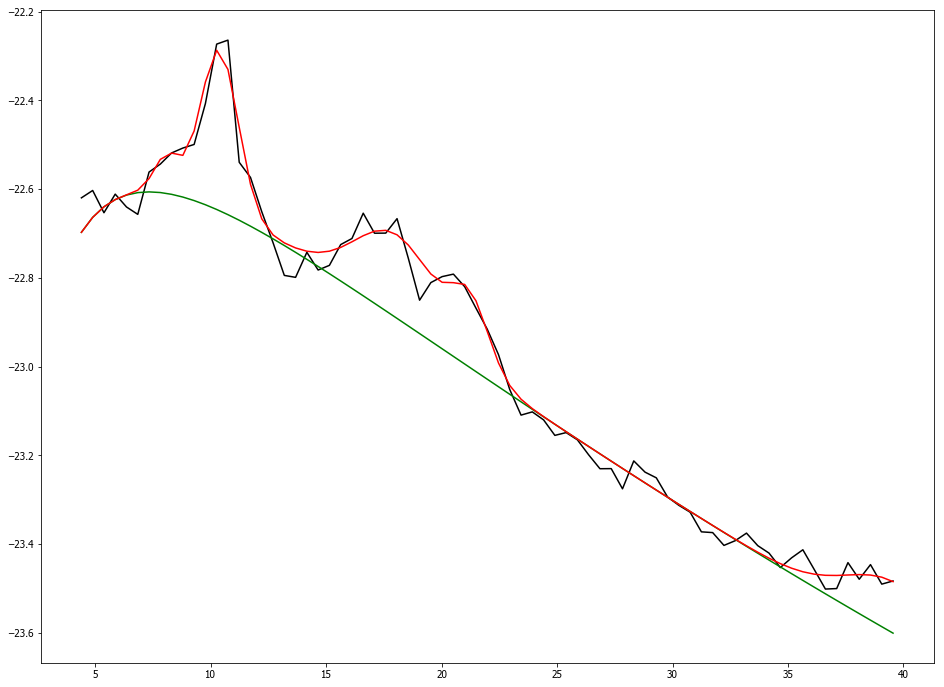

In [17]:
# Plot initial fit
plt.plot(frequency_vector, trimmed_psd, 'k')
plt.plot(frequency_vector, background_fit, 'g')
plt.plot(frequency_vector, psd_fit, 'r')

In [18]:
# Check RMSE of initial fit
rmse_orig = rmse(psd_fit, trimmed_psd)
print(rmse_orig)

0.0320226502676


In [19]:
# Optimize FOOOF
guess = oscillation_params
guess = sorted(guess, key=itemgetter(1), reverse=True)

if guess:
    popt, _ = curve_fit(gaussian_function, frequency_vector, p_flat_real, p0=guess, maxfev=5000)
    multi_fit = gaussian_function(frequency_vector, *popt)
    psd_fit = multi_fit + background_fit

else:
    print('Cant optimize empty oscillation parameters')

In [20]:
print('Background:', background_params, '\n')
print('Original Oscillations:')
for ll in sorted(oscillation_params): print(ll)
print('\nOptimized Oscillations: ')
for ll in sorted(group_three(popt)): print(ll)

Background: [-23.99169368   3.2046408   -1.85310994] 

Original Oscillations:
[8.1053969593931736, 0.083190538952451834, 0.76903048553904685]
[10.371705908150775, 0.36239263410180683, 1.1594092655789323]
[18.073355570744749, 0.18829813736124823, 2.5634449389830323]
[21.236808452711621, 0.13361485830289732, 1.1550123112283168]
[39.68438857307342, 0.11633869129609009, 3.0224055295065217]

Optimized Oscillations: 
[8.5614886736361608, 0.10211436550057235, 1.1573688835249984]
[10.484315850054104, 0.39542470381977035, 0.86000712978888905]
[17.422358518036852, 0.19860574941367226, 1.7317240007872929]
[20.875223016350436, 0.18260405750646244, 1.4531481851805523]
[50.038459912086033, 0.54808777468308523, 8.6185895953824492]


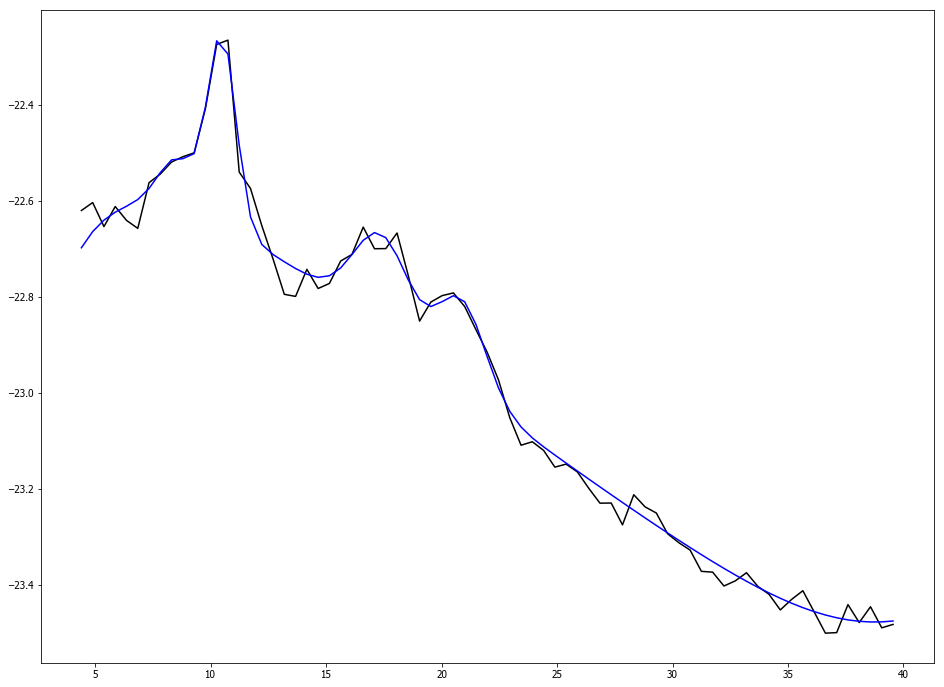

In [21]:
# Plot FOOOF Fits - after optimization
plt.plot(frequency_vector, trimmed_psd, 'k')
plt.plot(frequency_vector, psd_fit, 'b')
plt.show()

In [22]:
# Check errors after optimization
rmse_opt = rmse(psd_fit, trimmed_psd)
print(rmse_opt)

0.0285166915333


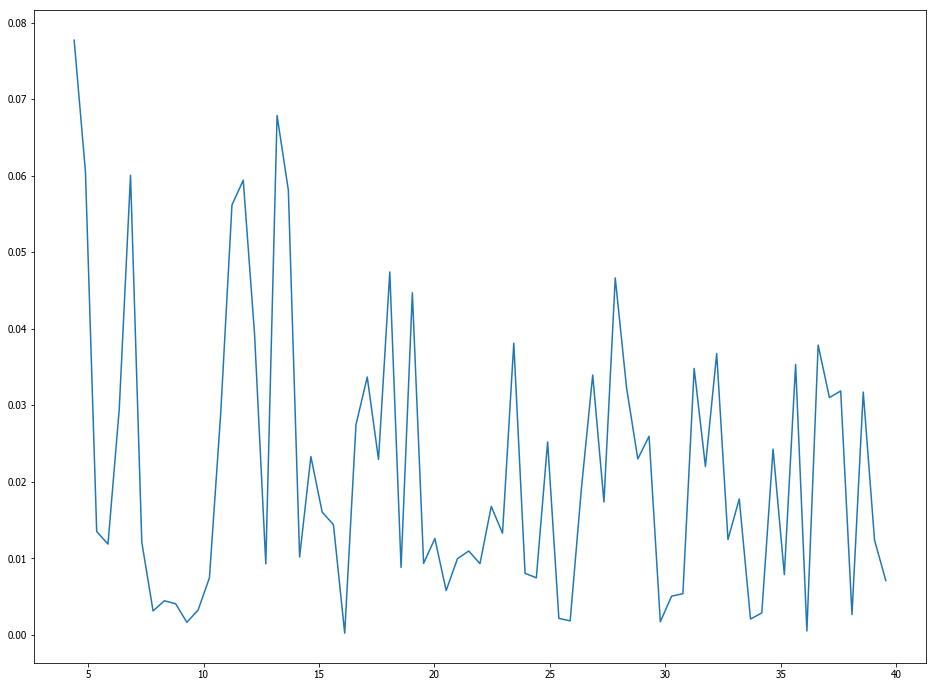

In [23]:
# Check error per frequency
abs_ef = abs_err_freq(psd_fit, trimmed_psd)
plt.plot(frequency_vector, abs_ef)

In [24]:
# Compare RMSEs
print(rmse_orig)
print(rmse_opt)

0.0320226502676
0.0285166915333


### EEG Data

In [ ]:
# Load
dat = np.load('data-for-tom.npy').item()

# Get freqs & unembed from being an array of arrays
freqs = dat['f']
freqs = np.array([f[0] for f in freqs])

In [ ]:
# Grab psd of interest
psd = dat[0][20]['eyeso']

In [ ]:
psd_array = np.log10(psd)
psd_array = np.vstack((psd_array, psd_array))
psd_array = psd_array.T

In [ ]:
# FOOOF SETTINGS
window_around_max = 3
number_of_gaussians = 6
cut_freqs = [3, 40]

In [ ]:
# Run FOOOF
p_flat_real, frequency_vector, trimmed_psd, psd_fit, background_fit, gaussian_fit, background_params, oscillation_params = \
    fooof(freqs, psd_array, cut_freqs, number_of_gaussians, window_around_max)

In [ ]:
# Optimize FOOOF
guess = oscillation_params
guess = sorted(guess, key=itemgetter(1), reverse=True)

popt, _ = curve_fit(gaussian_function, frequency_vector, p_flat_real, p0=guess, maxfev=5000)
multi_fit = gaussian_function(frequency_vector, *popt)

In [ ]:
print(background_params, '\n')
for ll in oscillation_params: print(ll)
print('\n')
print(popt)

In [ ]:
# Plot FOOOF Fits
plt.plot(frequency_vector, trimmed_psd, 'k')
plt.plot(frequency_vector, psd_fit, 'r')
plt.plot(frequency_vector, multi_fit+background_fit, 'b')
plt.show()